# Unsupervised Algorithms in Machine Learning - Final Project

Peer-graded Assignment: Mall Customer Segmentation Data

## 0. Introduction

This notebook contains the final project of the course Unsupervised Algorithms in Machine Learning. In this notebook, the hierarchical clustering method is used for classifying mall customers, based on their age, gender, annual income and spending score. The dataset can be found on Kaggle ("https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python").

The notebook contains the following parts:

1. Exploratory data analysis

2. Applying the CNN algorithm

3. Compare with other clustering method

4. Conclusions

## 1. EDA 

### 1.1 Loading data

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

# Clustering algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# Preprocessing and scaling
from sklearn.preprocessing import StandardScaler

# Clustering evaluation metrics
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score

# Statistics and statistical tests
from scipy.stats import norm, boxcox
from scipy import stats

# Hierarchical clustering
import scipy.cluster.hierarchy as sch

# Profiling report for quick analysis
from pandas_profiling import ProfileReport

# Ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)

pio.renderers.default = 'iframe_connected'  # Change the renderer if any plot fails

In [2]:
dataset = pd.read_csv('../input/customer-segmentation-tutorial-in-python/Mall_Customers.csv', index_col=0)

### 1.2 Exploration

The exploration contains:
1. Basic check (including numbers, sizes, missing values, abnormal values)
2. Blance check (if the categories are representative for all the categories)
3. Characteristic check for differences (through color distributions)

First, let us check the number by the following. The results shows the data is in right type, and there are no missing values.

In [3]:
dataset.head()
dataset.shape
dataset.describe()
dataset.info()
dataset.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

The next is to check the representations of the predictors (geder, age, annual income, and spending score). First it is the distributions in each category. The results show they are relatively evenly spread except the income. But this is plausible as the number of high income people tends to fewer.

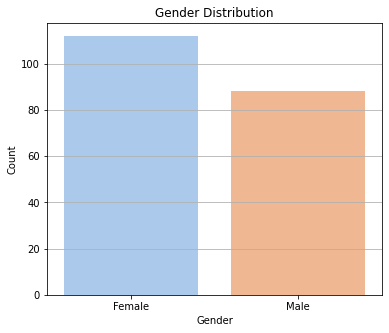

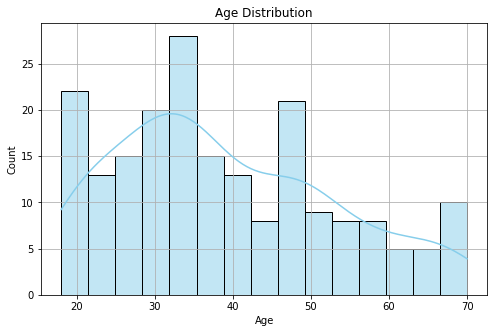

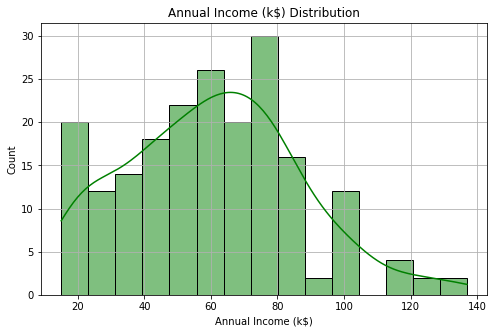

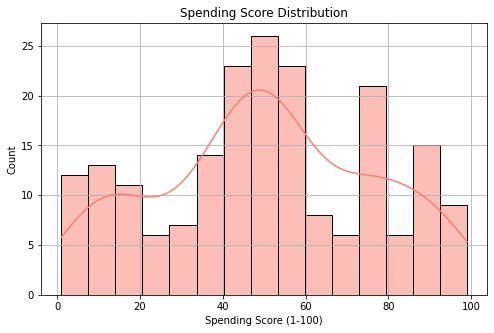

In [4]:
# Gender distribution
gender_counts = dataset['Gender'].value_counts()
plt.figure(figsize=(6, 5))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pastel')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

# 2. Age distribution - Histogram with KDE curve
plt.figure(figsize=(8, 5))
sns.histplot(dataset['Age'], bins=15, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# 3. Annual Income distribution - Histogram
plt.figure(figsize=(8, 5))
sns.histplot(dataset['Annual Income (k$)'], bins=15, kde=True, color='green')
plt.title('Annual Income (k$) Distribution')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# 4. Spending Score distribution - Histogram
plt.figure(figsize=(8, 5))
sns.histplot(dataset['Spending Score (1-100)'], bins=15, kde=True, color='salmon')
plt.title('Spending Score Distribution')
plt.xlabel('Spending Score (1-100)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

Now take a look at if the data is biased by considering the genders as two blocks. From the interactions between the gener and each of the others, I could find if the data is representative enough.

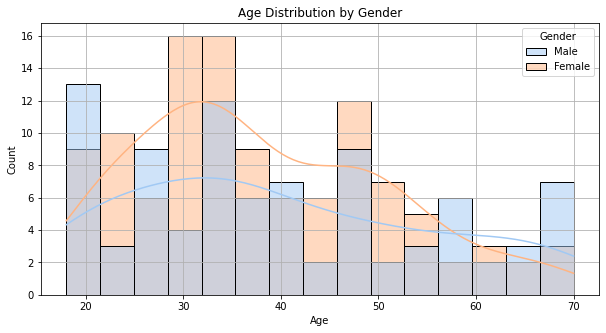

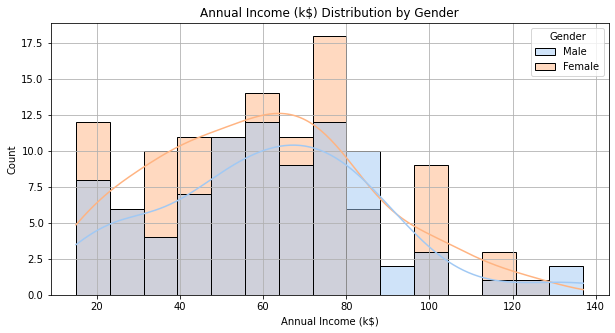

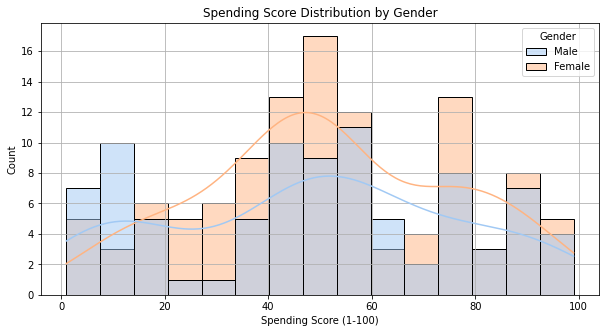

In [5]:
# Age distribution by Gender
plt.figure(figsize=(10, 5))
sns.histplot(data=dataset, x='Age', hue='Gender', bins=15, kde=True, palette='pastel')
plt.title('Age Distribution by Gender')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Annual Income distribution by Gender
plt.figure(figsize=(10, 5))
sns.histplot(data=dataset, x='Annual Income (k$)', hue='Gender', bins=15, kde=True, palette='pastel')
plt.title('Annual Income (k$) Distribution by Gender')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Spending Score distribution by Gender
plt.figure(figsize=(10, 5))
sns.histplot(data=dataset, x='Spending Score (1-100)', hue='Gender', bins=15, kde=True, palette='pastel')
plt.title('Spending Score Distribution by Gender')
plt.xlabel('Spending Score (1-100)')
plt.ylabel('Count')
plt.grid(True)
plt.show()


Between two genders:
1. the age is most balanced
2. the income looks like in a normal distribution, but has light right tail, but it is plausible as the rich is few
3. the spending score is clustered in low, mid, three groups.

The age distribution is relatively balanced between genders, with similar range and spread observed for both males and females. The Annual Income distribution approximates a normal distribution but displays slight positive skewness, which is expected as higher-income individuals are naturally fewer. The Spending Score distribution exhibits multimodal clustering, with identifiable low, mid, and high spending groups, indicating the presence of distinct consumer behavior segments within the data.

Next, plot a pairplot to visualize the correlations.

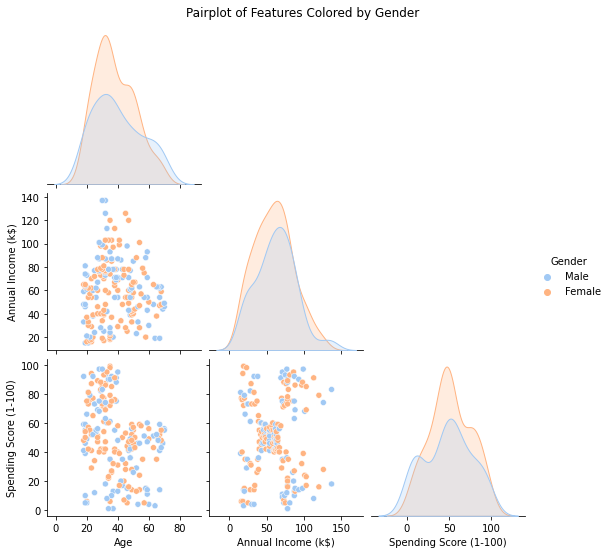

In [6]:
# Pairplot colored by Gender
sns.pairplot(dataset, hue='Gender', palette='pastel', diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Features Colored by Gender', y=1.02)
plt.show()

It can be found that:
1. The annual income vs age scatters most evenly
2. There is a trend between spending score and age, which suggesting elder people spend less
3. The spending score seems be clustered by annual income. Both low and high income consumers have two consuming beheviros (high and low spending), while medium income consumers have medium comsuming behaviors.
4. 
Go on and plot a correlation matrix. It observed that the spending negatively related to the increasing of age.

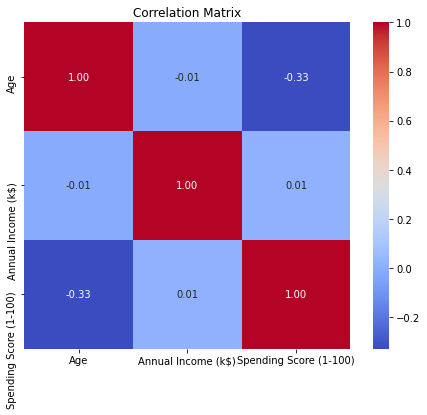

In [7]:
# Calculate correlation matrix
corr_matrix = dataset.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.show()

### 1.3 EDA summary

From the exploration, I already find some characteristics between the categoreis. Especially, if the customers are classified by annual income and speeding score, five clusters can be formed. In the next part, this is handled by hierarchical clustering.

## 2. Hierarchical clustering

### 2.1 Hierrchical clustering

First, let us follow the EDA summary, and cluster the customers by annual income and spending score.

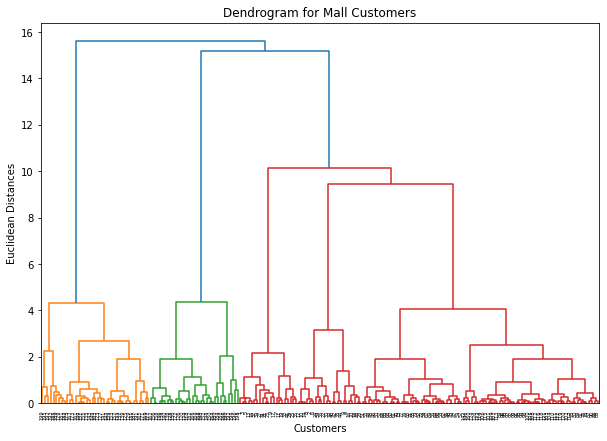

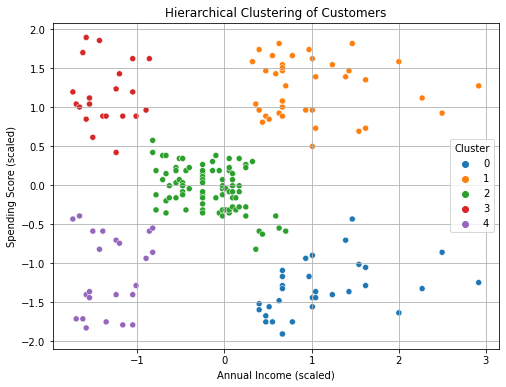

In [8]:
# Select features (typically Income and Spending Score for this dataset)
X_2d = dataset[['Annual Income (k$)', 'Spending Score (1-100)']]

# Scale the features
scaler = StandardScaler()
X_scaled_2d = scaler.fit_transform(X_2d)

# Create and plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(X_scaled_2d, method='ward'))
plt.title('Dendrogram for Mall Customers')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.show()

# Fit hierarchical clustering
hc_2d = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
y_hc_2d = hc_2d.fit_predict(X_scaled_2d)

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_scaled_2d[:, 0], y=X_scaled_2d[:, 1], hue=y_hc_2d, palette='tab10', legend='full')
plt.title('Hierarchical Clustering of Customers')
plt.xlabel('Annual Income (scaled)')
plt.ylabel('Spending Score (scaled)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

We also find Age would influcence the spending, and let us add it in the model.

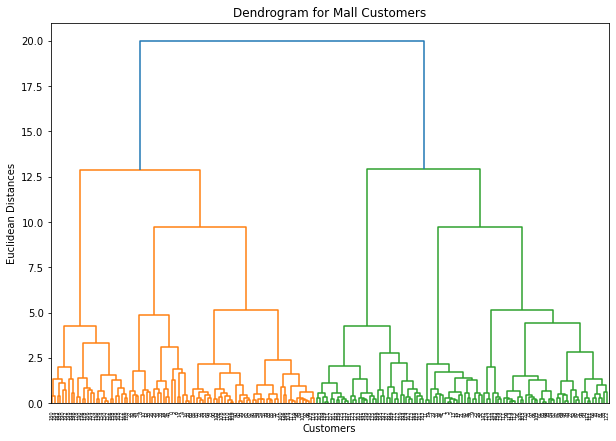

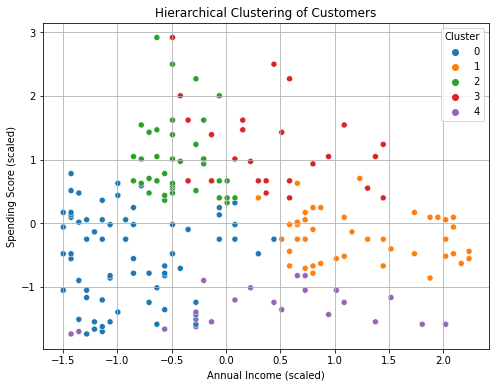

In [9]:
# Select features (typically Income and Spending Score for this dataset)
X_2d_3 = dataset[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Scale the features
scaler = StandardScaler()
X_scaled_2d_3 = scaler.fit_transform(X_2d_3)

# Create and plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(X_scaled_2d_3, method='ward'))
plt.title('Dendrogram for Mall Customers')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.show()

# Fit hierarchical clustering
hc_2d_3 = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
y_hc_2d_3 = hc_2d_3.fit_predict(X_scaled_2d_3)

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_scaled_2d_3[:, 0], y=X_scaled_2d_3[:, 1], hue=y_hc_2d_3, palette='tab10', legend='full')
plt.title('Hierarchical Clustering of Customers')
plt.xlabel('Annual Income (scaled)')
plt.ylabel('Spending Score (scaled)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

Compare the two models, the first model gives more distinct clusters. Now let us build a 3D hierarchical cluster model for visualization.

In [10]:
# Select 3 features
X_3d = dataset[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
X_scaled_3d = scaler.fit_transform(X_3d)

# Apply Agglomerative Clustering
n_clusters = 5  # or based on your dendrogram
hc_3d = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
y_hc_3d = hc_3d.fit_predict(X_scaled_3d)

# Plot 3D scatter plot
fig = px.scatter_3d(
    x=X_scaled_3d[:, 0],  # Age (scaled)
    y=X_scaled_3d[:, 1],  # Income (scaled)
    z=X_scaled_3d[:, 2],  # Spending Score (scaled)
    color=y_hc_3d.astype(str),  # Convert cluster labels to string
    labels={'x': 'Age (scaled)', 'y': 'Annual Income (scaled)', 'z': 'Spending Score (scaled)'},
    title='3D Clustering of Mall Customers'
)
fig.show()

### 2.2 Evaluation of Hierarchical clustering models

The evaluation criterion include:
1. Silhouette Score: How well the clustering algorithm has defined distinct clusters Higher score indicates well-separated clusters.
2. Adjusted Rand Index: Compare two clustering results. Higher index indicates similar clusters.
3. Davies-Bouldin Index: Evaluate both compactness and separation of clusters. Lower index indicates compact and well-seperated clusters.

In [11]:
# For 2D hierarchical clustering
sil_score_2d_1 = silhouette_score(X_scaled_2d, y_hc_2d)
sil_score_2d_2 = silhouette_score(X_scaled_2d_3, y_hc_2d_3)

# For 3D hierarchical clustering
sil_score_3d = silhouette_score(X_scaled_3d, y_hc_3d)

print(f"Silhouette Score for 2D Model 1: {sil_score_2d_1}")
print(f"Silhouette Score for 2D Model 2: {sil_score_2d_2}")
print(f"Silhouette Score for 3D Model: {sil_score_3d}")

Silhouette Score for 2D Model 1: 0.5538089226688662
Silhouette Score for 2D Model 2: 0.39002826186267214
Silhouette Score for 3D Model: 0.39002826186267214


In [12]:
# You need the true labels for ARI. If you don't have them, ARI is just used for comparing two clusterings.
ari_2d_1_vs_2 = adjusted_rand_score(y_hc_2d, y_hc_2d_3)
ari_2d_1_vs_3d = adjusted_rand_score(y_hc_2d, y_hc_3d)
ari_2d_2_vs_3d = adjusted_rand_score(y_hc_2d_3, y_hc_3d)

print(f"ARI between 2D Model 1 and 2D Model 2: {ari_2d_1_vs_2}")
print(f"ARI between 2D Model 1 and 3D Model: {ari_2d_1_vs_3d}")
print(f"ARI between 2D Model 2 and 3D Model: {ari_2d_2_vs_3d}")

ARI between 2D Model 1 and 2D Model 2: 0.581138502144327
ARI between 2D Model 1 and 3D Model: 0.581138502144327
ARI between 2D Model 2 and 3D Model: 1.0


In [13]:
# For 2D hierarchical clustering
db_index_2d_1 = davies_bouldin_score(X_scaled_2d, y_hc_2d)
db_index_2d_2 = davies_bouldin_score(X_scaled_2d_3, y_hc_2d_3)

# For 3D hierarchical clustering
db_index_3d = davies_bouldin_score(X_scaled_3d, y_hc_3d)

print(f"Davies-Bouldin Index for 2D Model 1: {db_index_2d_1}")
print(f"Davies-Bouldin Index for 2D Model 2: {db_index_2d_2}")
print(f"Davies-Bouldin Index for 3D Model: {db_index_3d}")

Davies-Bouldin Index for 2D Model 1: 0.5778621190740154
Davies-Bouldin Index for 2D Model 2: 0.9162886109753661
Davies-Bouldin Index for 3D Model: 0.9162886109753661


From the results, we can conclude the best predictors for hierarchical clustering are annual income and speeding score, which is consistent with our EDA summary.

## 3. Compare with other clustering methods

In this part, I will compare hierarchical clustering with the Kmeans and DBSCAN methods.

In [14]:
# Select features and scale them
X = dataset[['Annual Income (k$)', 'Spending Score (1-100)']]  
X_scaled = scaler.fit_transform(X)

X_3 = dataset[['Age','Annual Income (k$)', 'Spending Score (1-100)']]  
X_scaled_3 = scaler.fit_transform(X_3)

# Optimal Agglomerative Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
y_hc = hc.fit_predict(X_scaled)

# K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled_3)

# DBSCAN 
dbscan = DBSCAN(eps=0.5, min_samples=5)
y_dbscan = dbscan.fit_predict(X_scaled_3)

In [15]:
# Compare Silhouette Scores
sil_score_hc = silhouette_score(X_scaled, y_hc)
sil_score_kmeans = silhouette_score(X_scaled, y_kmeans)
sil_score_dbscan = silhouette_score(X_scaled, y_dbscan)

# Inertia (only for K-Means) 
inertia_kmeans = kmeans.inertia_

In [16]:
def calculate_cohesion_separation(X_scaled, labels):
    unique_labels = np.unique(labels)
    
    # Ignore noise points (label = -1) for DBSCAN
    unique_labels = unique_labels[unique_labels != -1]
    
    cluster_centers = []
    for label in unique_labels:
        cluster_points = X_scaled[labels == label]
        cluster_center = np.mean(cluster_points, axis=0)
        cluster_centers.append(cluster_center)
    cluster_centers = np.vstack(cluster_centers)
    
    # Now calculate cohesion
    cohesion = np.mean([np.sum((X_scaled[labels == label] - center) ** 2)
                        for label, center in zip(unique_labels, cluster_centers)])
    
    # Calculate separation
    separation = np.mean([np.linalg.norm(cluster_centers[i] - cluster_centers[j])
                          for i in range(len(cluster_centers))
                          for j in range(i + 1, len(cluster_centers))])
    
    return cohesion, separation

                      Model  Silhouette Score  Inertia (K-Means Only)  \
0  Agglomerative Clustering          0.553809                     NaN   
1        K-Means Clustering          0.296071               168.24758   
2                    DBSCAN          0.017632                     NaN   

    Cohesion  Separation  
0  13.303301    2.327050  
1  20.322724    1.980560  
2   4.149655    1.797456  


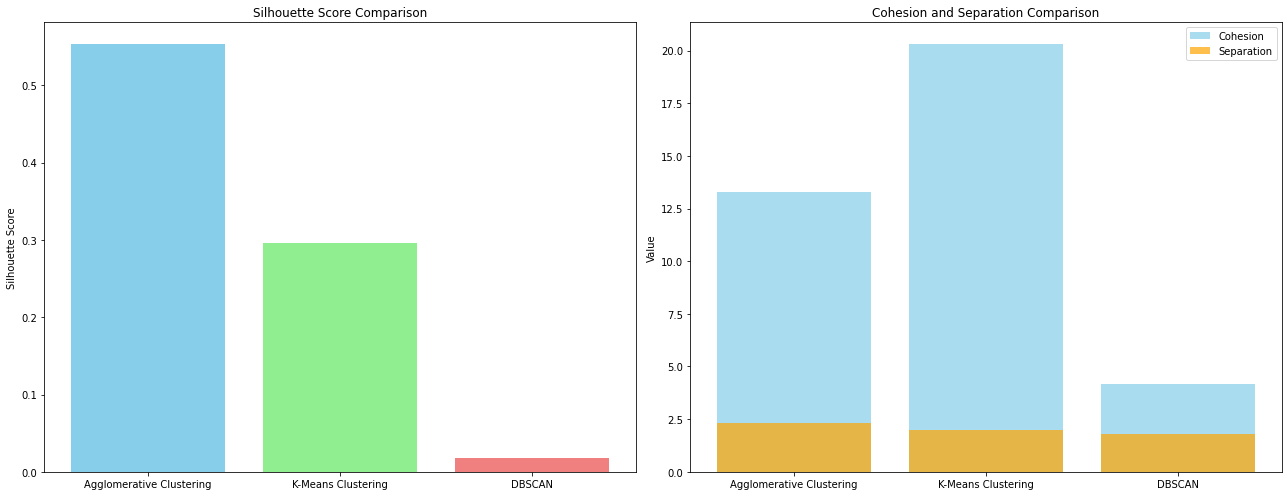

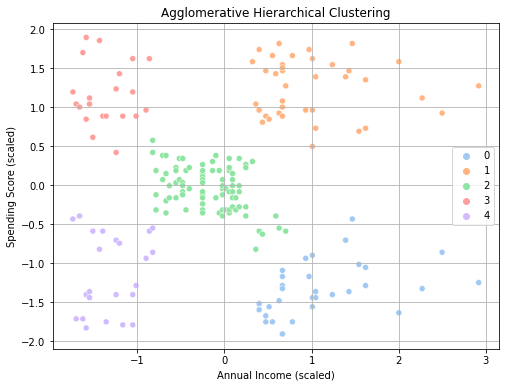

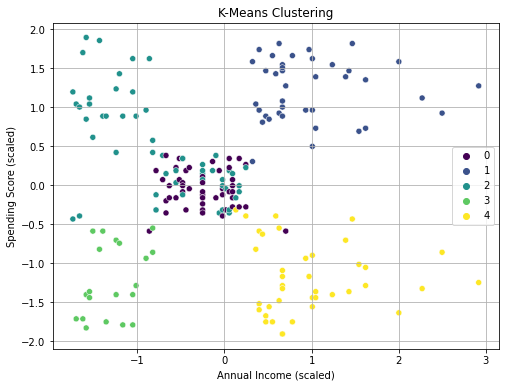

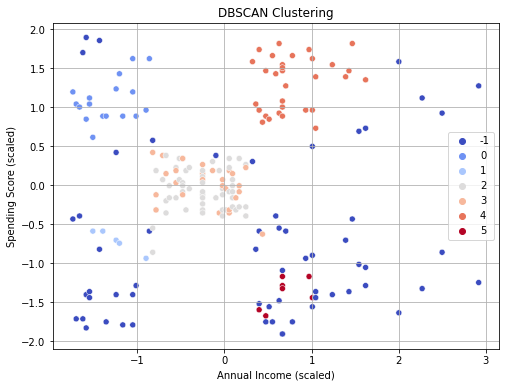

In [17]:
# Print Results Table
cohesion_hc, separation_hc = calculate_cohesion_separation(X_scaled, y_hc)
cohesion_kmeans, separation_kmeans = calculate_cohesion_separation(X_scaled, y_kmeans)
cohesion_dbscan, separation_dbscan = calculate_cohesion_separation(X_scaled, y_dbscan)

# Summarize the Results
results = pd.DataFrame({
    'Model': ['Agglomerative Clustering', 'K-Means Clustering', 'DBSCAN'],
    'Silhouette Score': [sil_score_hc, sil_score_kmeans, sil_score_dbscan],
    'Inertia (K-Means Only)': [None, inertia_kmeans, None],
    'Cohesion': [cohesion_hc, cohesion_kmeans, cohesion_dbscan],
    'Separation': [separation_hc, separation_kmeans, separation_dbscan]
})

# Print Results Table
print(results)

# Plot Results
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Silhouette Score Comparison
axes[0].bar(results['Model'], results['Silhouette Score'], color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0].set_title('Silhouette Score Comparison')
axes[0].set_ylabel('Silhouette Score')

# Cohesion and Separation Comparison
axes[1].bar(results['Model'], results['Cohesion'], label='Cohesion', alpha=0.7, color='skyblue')
axes[1].bar(results['Model'], results['Separation'], label='Separation', alpha=0.7, color='orange')
axes[1].set_title('Cohesion and Separation Comparison')
axes[1].set_ylabel('Value')
axes[1].legend()
plt.tight_layout()
plt.show()

# Plotting Clusters for each model
# Agglomerative Clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=y_hc, palette='pastel', legend='full')
plt.title('Agglomerative Hierarchical Clustering')
plt.xlabel('Annual Income (scaled)')
plt.ylabel('Spending Score (scaled)')
plt.grid(True)
plt.show()

# K-Means Clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=y_kmeans, palette='viridis', legend='full')
plt.title('K-Means Clustering')
plt.xlabel('Annual Income (scaled)')
plt.ylabel('Spending Score (scaled)')
plt.grid(True)
plt.show()

# DBSCAN Clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=y_dbscan, palette='coolwarm', legend='full')
plt.title('DBSCAN Clustering')
plt.xlabel('Annual Income (scaled)')
plt.ylabel('Spending Score (scaled)')
plt.grid(True)
plt.show()

The comparison is based on three criterion:
1. Silhouette Score.
2. Cohesion: Within-cluster variance
3. Separation: Between-cluster distance

Based on the comparison, it concludes that:
1. The hierarchical model gives best separation.
2. The hierarchical model gives the best balance between within and between cluster distances.
3. The visualizations are consistent with the indices.

## 4. Conclusion:

In this final project, a hierarchical clustering model is built for identifying customers according to recorded four features. The conclusions are:
1. Two features (annual income and spending score) are best suitable for clustering. This is proved by buiding three different hierarchical clustering models, and consistent with the exploratory data analysis. 
2. Two other clustering methods (Kmeans and DBSCAN). The result shows the hierarchical clustering model gives best seperation, and balance between within and between cluster distances.